In [14]:
import sys
sys.path.append('/home/yhuang2/PROJs/NeuralCompression_2d/neuralcompress/')
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.jit import load
import torch.nn.functional as F 

In [2]:
from dataset import DatasetTPC2d

ModuleNotFoundError: No module named 'dataset'

In [5]:
MANIFEST_TEST = '/data/datasets/sphenix/highest_framedata_3d/outer/test.txt'
dataset_test = DatasetTPC2d(MANIFEST_TEST)

In [20]:
checkpoint_path_enc = '../neuralcompress/checkpoints/enc_last.pth'
checkpoint_path_dec = '../neuralcompress/checkpoints/dec_last.pth'

encoder = load(checkpoint_path_enc, map_location=torch.device('cuda'))
decoder = load(checkpoint_path_dec, map_location=torch.device('cuda'))

_ = encoder.eval()
_ = decoder.eval()

## Compression ratio

In [18]:
data = dataset_test[0].unsqueeze(0).to('cuda')
compr = encoder(data)
compr_ratio = data.numel() / compr.numel()
print(f'Compression Ratio = {compr_ratio}')

Compression Ratio = 32.0


In [57]:
def to_numpy(tensor):
    return tensor.detach().cpu().squeeze().numpy()
def log(array):
    return np.log2(1. + array)
def zero_suppress(array, cutoff):
    brray = array.copy()
    brray[brray < cutoff] = 0
    return brray

def codec(encoder, decoder, data):
    
    code = encoder(data.unsqueeze(0).to('cuda'))
    decompressed = decoder(code).squeeze()
    
    return to_numpy(code), to_numpy(decompressed)

## One-dimension distribution

In [53]:
raw = dataset_test[1]
code, decompressed = codec(encoder, decoder, raw)

-19.924702


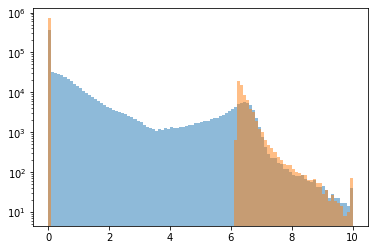

In [81]:
fig, ax = plt.subplots(1, 1)
ax.set_yscale('log')

grt = to_numpy(raw).flatten()
prd = decompressed.flatten()
print(prd.min())
prd_z = zero_suppress(prd, 64)
prd_c = prd.copy()
prd_c[prd_c > 1023] = 1023
prd_c[prd_c < 0] = 0 
_ = ax.hist(np.log2(prd_c + 1), bins = 100, alpha=.5)
_ = ax.hist(np.log2(grt + 1), bins = 100, alpha=.5)

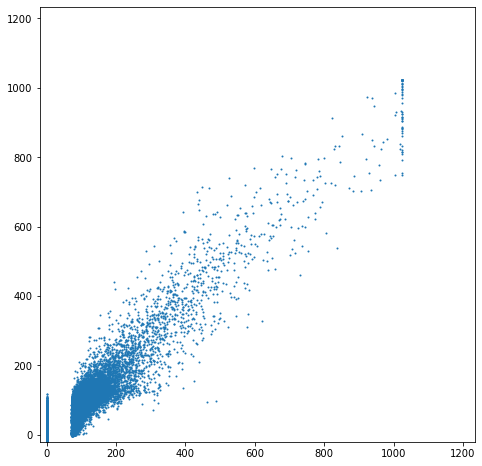

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_aspect(1)
ax.set_xlim(prd.min(), prd.max())
ax.set_ylim(prd.min(), prd.max())
ax.scatter(grt, prd_c, s=1)

In [77]:
np.power(grt - prd_c, 2).mean()

128.655

In [3]:
import numpy as np

0.9312
1.360803121908481e-05
0.0006596574682225996


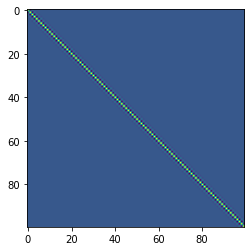

In [131]:
num = 100
matrix = 3 * np.eye(num, num) + np.diag([1] * (num - 1), k = 1) + np.diag([1] * (num - 1), k = -1)
inv = np.linalg.inv(matrix)
inv_a = inv.copy()
inv_a[np.abs(inv_a) < 1e-2] = 0

zero_fraction = (inv_a == 0).sum() / (num ** 2)
print(zero_fraction)

ia = np.matmul(inv_a, matrix)
mse = np.power(ia - np.eye(num), 2).mean()
mae = np.abs(ia - np.eye(num)).mean()
print(mse)
print(mae)

plt.imshow(inv_a)

In [129]:
print(inv_a)

[[ 0.38196601 -0.14589803  0.05572809 ...  0.          0.
   0.        ]
 [-0.14589803  0.4376941  -0.16718427 ...  0.          0.
   0.        ]
 [ 0.05572809 -0.16718427  0.44582472 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.44582472 -0.16718427
   0.05572809]
 [ 0.          0.          0.         ... -0.16718427  0.4376941
  -0.14589803]
 [ 0.          0.          0.         ...  0.05572809 -0.14589803
   0.38196601]]


In [135]:
import torch
a = torch.tensor([1, 2, 3], dtype=torch.float32)
a = torch.tensor([1, 2, 3])
b = (a <= 1).to(torch.long)
print(b.type())

torch.LongTensor


In [137]:
from torch import nn
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)

In [138]:
target.type()

'torch.FloatTensor'

6.149747 10.0
(192, 249)


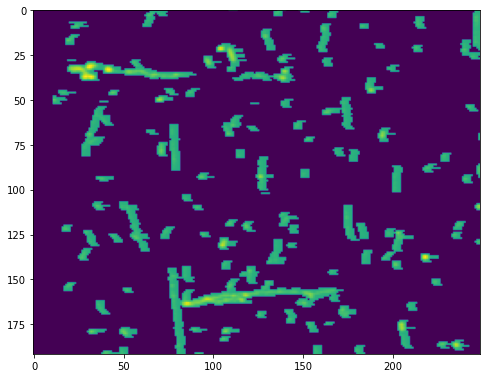

In [85]:
data = np.load('../data/AuAu200_170kHz_10C_Iter2_3178.xml_TPCMLDataInterface_9.npy')
frame = np.log2(data[:, :, 7] + 1)
print(frame[frame > 0].min(), frame.max())
print(frame.shape)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(frame)

tensor(0.1130) tensor(56.9898)


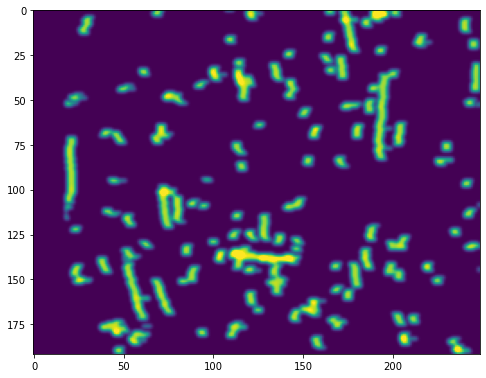

In [72]:
inputs = torch.tensor(frame).reshape(1, 1, *frame.shape)
weights = get_gaussian_weight(2, 1)
weights = weights.reshape(1, 1, *weights.shape)
filtered = F.conv_transpose2d(inputs, weights, padding=2)
print(filtered[filtered > 0].min(), filtered.max())
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(filtered.squeeze(), vmax=45)

# plt.hist(frame.flatten())

In [32]:
def get_gaussian_weight(wing, sigma=1):

    x_coord, y_coord = torch.meshgrid(torch.arange(-wing, wing + 1), 
                                      torch.arange(-wing, wing + 1), 
                                      indexing='xy')
    return torch.exp(-.5 * (x_coord ** 2 + y_coord ** 2) / (sigma ** 2))

In [53]:
get_gaussian_weight(2, sigma=1)

tensor([[0.0183, 0.0821, 0.1353, 0.0821, 0.0183],
        [0.0821, 0.3679, 0.6065, 0.3679, 0.0821],
        [0.1353, 0.6065, 1.0000, 0.6065, 0.1353],
        [0.0821, 0.3679, 0.6065, 0.3679, 0.0821],
        [0.0183, 0.0821, 0.1353, 0.0821, 0.0183]])

In [26]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(20, 10))
ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(res))) 
ls = LightSource(0, 45)
rgb = ls.shade(res, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, res, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

tensor([-2, -1,  0,  1])

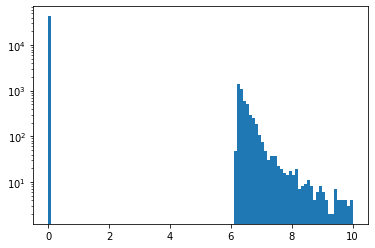

In [63]:
_ = plt.hist(frame.flatten(), bins=100)
plt.yscale('log')

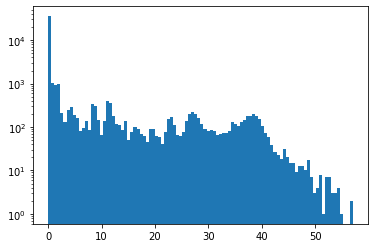

In [69]:
a = filtered.numpy().flatten()
_ = plt.hist(a, bins=100)
plt.yscale('log')

In [86]:
arr = np.random.randn(10, 4)

In [90]:
indices = np.where(arr[:, 2] > 0)

In [91]:
arr[indices]

array([[ 1.47401251,  2.11814945,  0.78474693, -0.14745861],
       [-0.62695833, -1.48184075,  0.35516116,  0.05090449],
       [ 0.56066886,  1.01587959,  2.04112833,  0.30966929],
       [ 0.35705314,  1.46803605,  1.51841223,  0.34052802],
       [-0.84827147,  0.11913096,  0.6077284 ,  0.58428209],
       [ 0.50787077,  1.97139609,  0.52141969,  1.27227292],
       [ 0.57196034,  0.56900827,  1.55129874, -0.68342422]])